In [1]:
import os
import librosa
from tqdm import tqdm
import librosa.display
import numpy as np
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv

In [2]:
def convert_to_mel_spectrogram(audio, sr, n_fft, hop_length, n_mels):
    if audio is None:
        return None
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels, fmax=sr / 2)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

In [3]:

# 指定 STFT 參數
load_dotenv()
sample_rate = int(os.getenv('sample_rate'))
hop_length = int(os.getenv('hop_length'))
n_mels = int(os.getenv('n_mels'))
n_fft = int(os.getenv('n_fft'))

print(f"hop_length: {hop_length}")
print(f"n_mels: {n_mels}")
print(f"n_fft: {n_fft}")
print(f"target_sample_rate: {sample_rate}")

hop_length: 256
n_mels: 64
n_fft: 1024
target_sample_rate: 44100


In [4]:
def load_segmented_files(directory):
    wav_files = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            y, sr = librosa.load(file_path, sr=None)
            path = file.split(os.path.sep)
            filename = f'{path[-1]}'
            wav_files.append((y, filename))
    return wav_files

In [5]:
# 讀取分割後的音訊片段
normal_segments = load_segmented_files('output')
anomaly_segments = load_segmented_files('output_anomaly')
# 打亂 mel_spectrograms_normal 列表
np.random.shuffle(normal_segments)
np.random.shuffle(anomaly_segments)

100%|██████████| 2345/2345 [00:01<00:00, 2267.01it/s]


In [6]:
mel_spectrograms_normal = []
mel_spectrograms_anomaly = []

for seg in tqdm(normal_segments):
    mel = convert_to_mel_spectrogram(seg[0], sample_rate, n_fft, hop_length, n_mels)
    if mel is None:
        continue
    mel_spectrograms_normal.append(mel)

for seg in tqdm(anomaly_segments[:len(mel_spectrograms_normal)]):
    mel = convert_to_mel_spectrogram(seg[0], sample_rate, n_fft, hop_length, n_mels)
    if mel is None:
        continue
    mel_spectrograms_anomaly.append(mel)

100%|██████████| 1554/1554 [00:08<00:00, 184.96it/s]


In [7]:
# 檢查 mel_spectrograms_normal 和 mel_spectrograms_anomaly 的長度
print("正常樣本數量:", len(mel_spectrograms_normal))
print("異常樣本數量:", len(mel_spectrograms_anomaly))
print("正常樣本形狀:", mel_spectrograms_normal[0].shape)
print("異常樣本形狀:", mel_spectrograms_anomaly[0].shape)
print("正常樣本最小值:", np.min(mel_spectrograms_normal))
print("正常樣本最大值:", np.max(mel_spectrograms_normal))

# 檢查有無 None 值
print("正常樣本中是否有 None 值:", any(ms is None for ms in mel_spectrograms_normal))
print("異常樣本中是否有 None 值:", any(ms is None for ms in mel_spectrograms_anomaly))

# 打印部分梅爾頻譜圖的基本統計信息
for i, mel in enumerate(mel_spectrograms_normal[:5]):
    print(f"正常樣本梅爾頻譜圖 {i+1} 的基本信息:")
    print(f"  最小值: {np.min(mel)}")
    print(f"  最大值: {np.max(mel)}")
    print(f"  平均值: {np.mean(mel)}")
    print(f"  標準差: {np.std(mel)}")

正常樣本數量: 1554
異常樣本數量: 1554
正常樣本形狀: (64, 690)
異常樣本形狀: (64, 690)
正常樣本最小值: -80.0
正常樣本最大值: 1.9073486e-06
正常樣本中是否有 None 值: False
異常樣本中是否有 None 值: False
正常樣本梅爾頻譜圖 1 的基本信息:
  最小值: -80.0
  最大值: 0.0
  平均值: -52.746307373046875
  標準差: 12.756601333618164
正常樣本梅爾頻譜圖 2 的基本信息:
  最小值: -80.0
  最大值: 0.0
  平均值: -51.98670196533203
  標準差: 15.262112617492676
正常樣本梅爾頻譜圖 3 的基本信息:
  最小值: -67.21099090576172
  最大值: 0.0
  平均值: -35.3422966003418
  標準差: 10.79081916809082
正常樣本梅爾頻譜圖 4 的基本信息:
  最小值: -79.13117980957031
  最大值: 0.0
  平均值: -49.5806884765625
  標準差: 11.176023483276367
正常樣本梅爾頻譜圖 5 的基本信息:
  最小值: -77.22416687011719
  最大值: 0.0
  平均值: -44.83060073852539
  標準差: 10.53337574005127


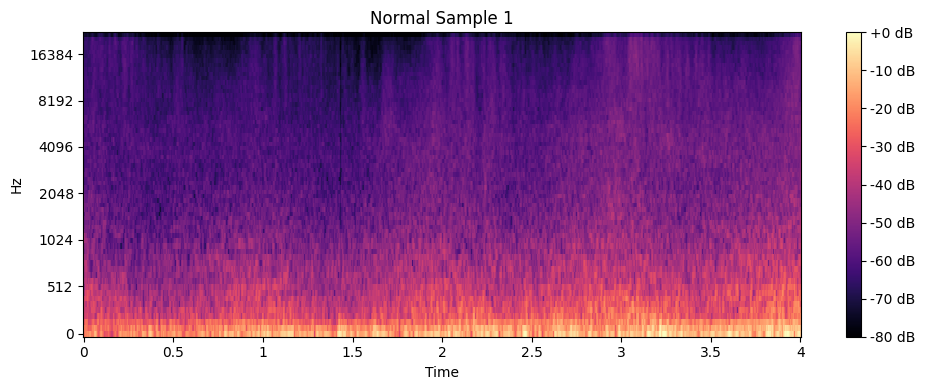

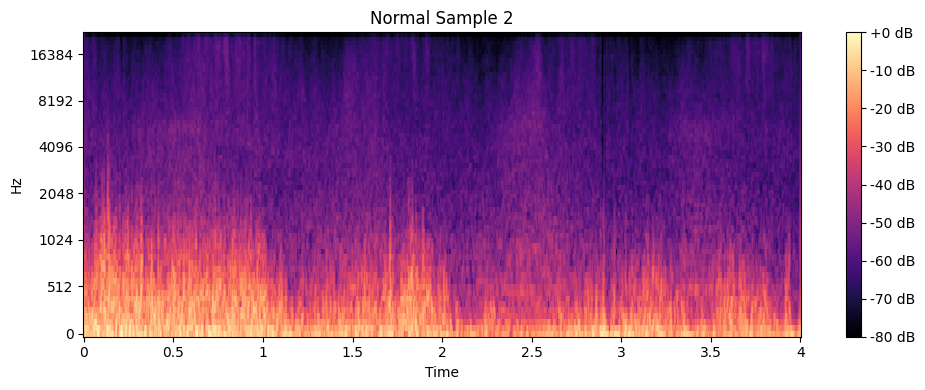

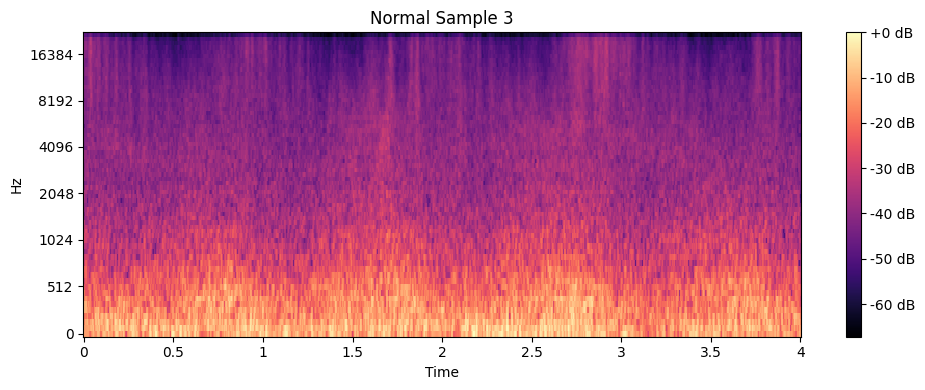

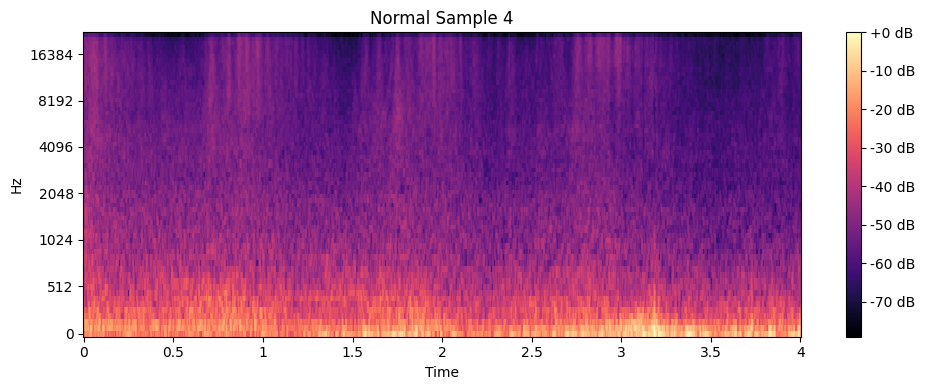

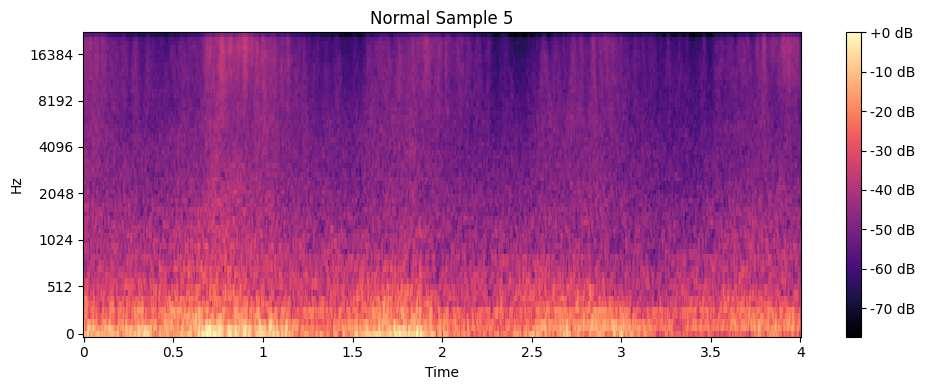

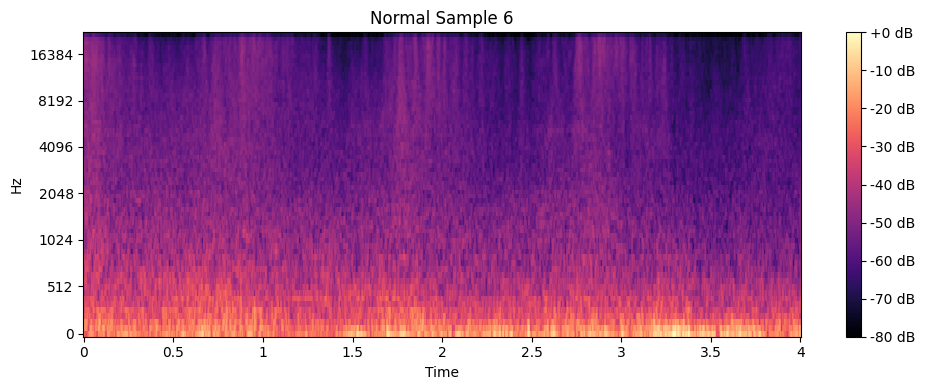

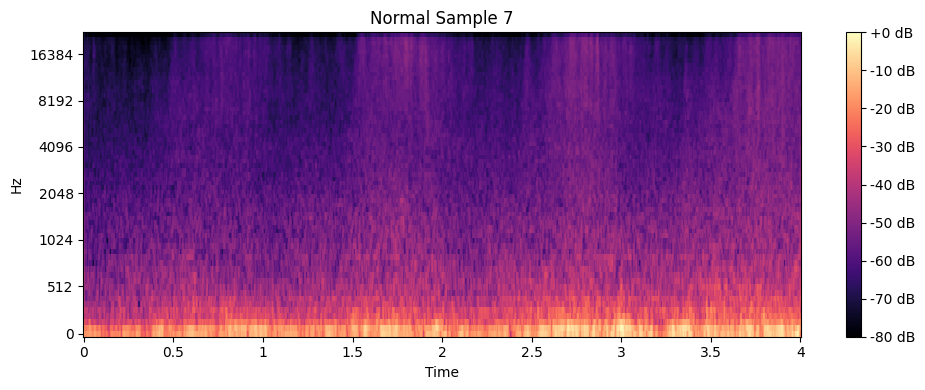

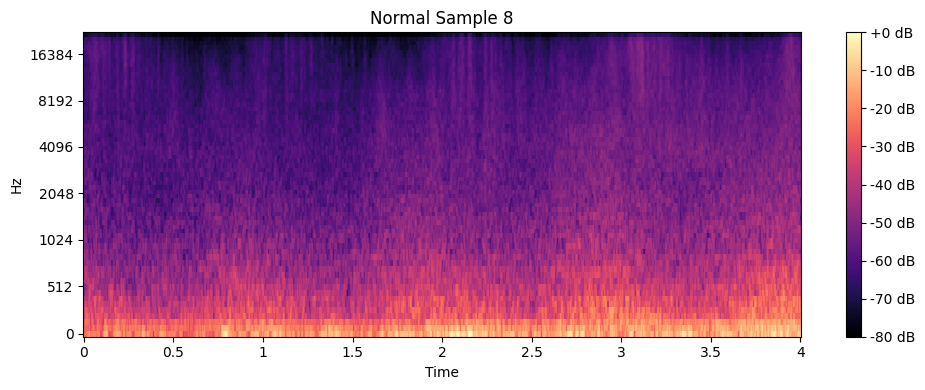

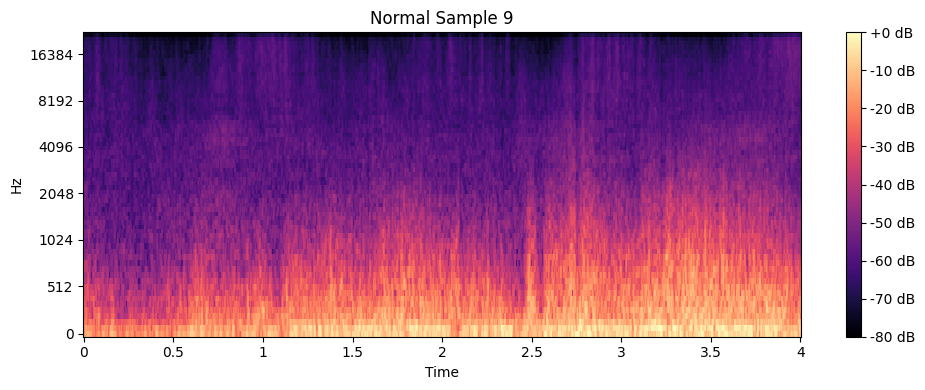

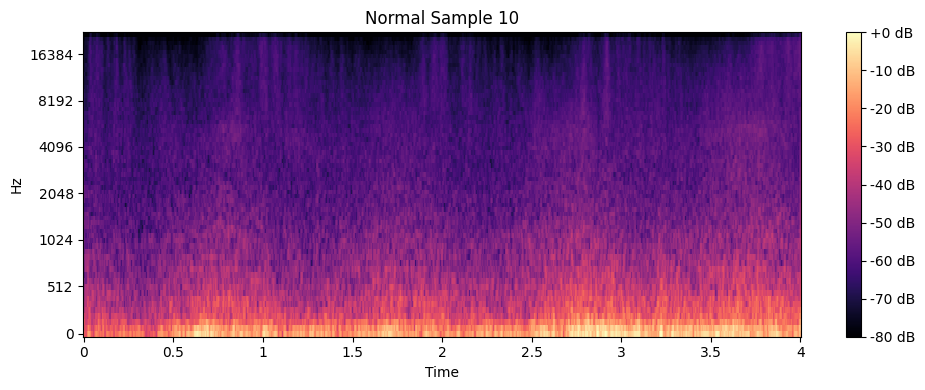

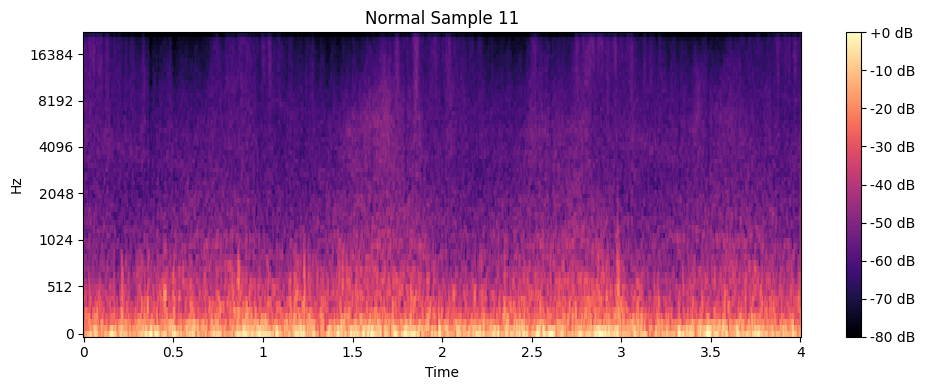

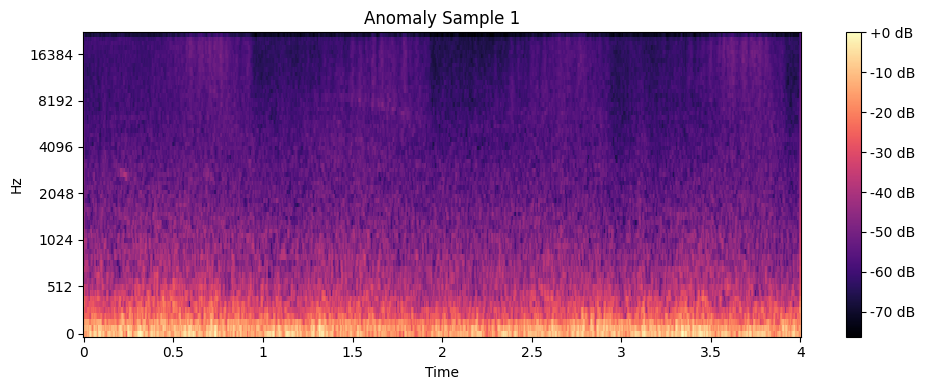

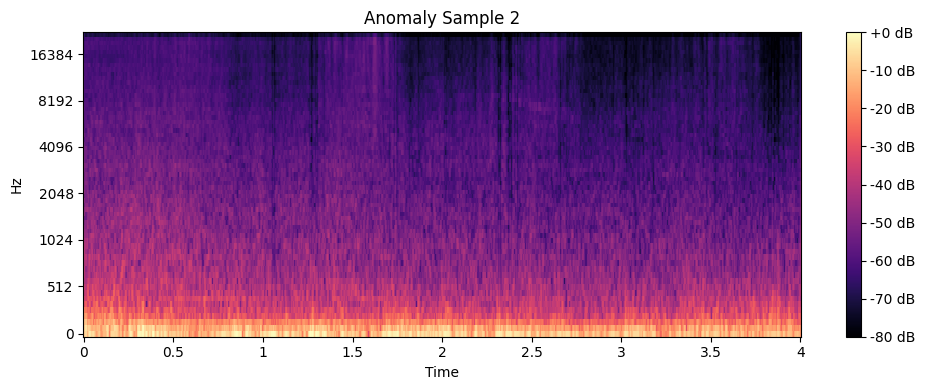

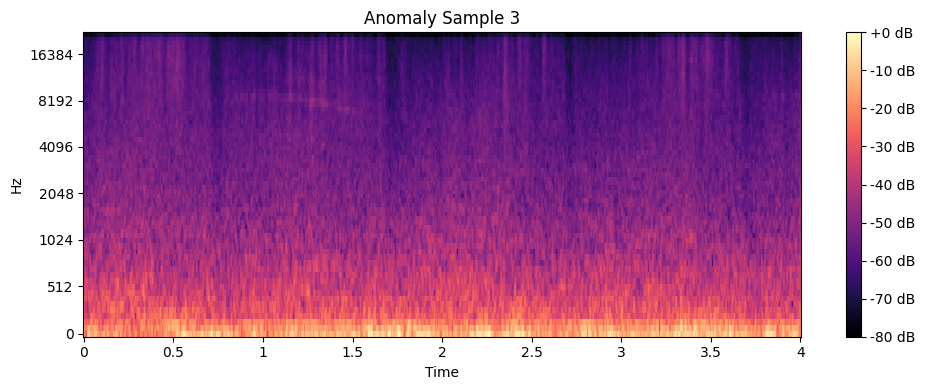

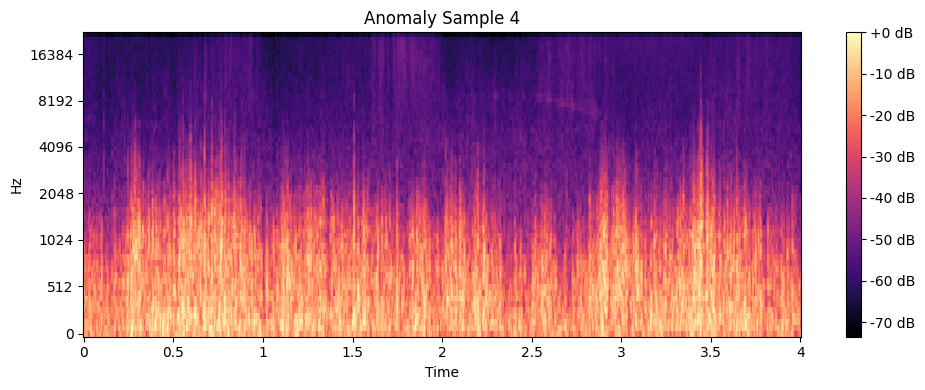

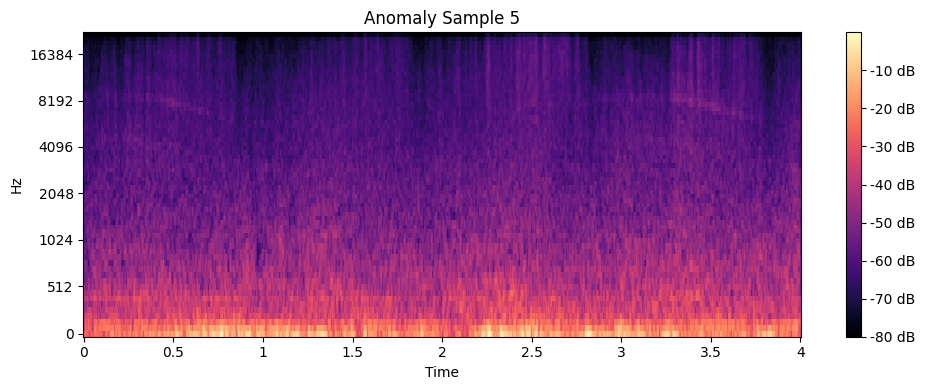

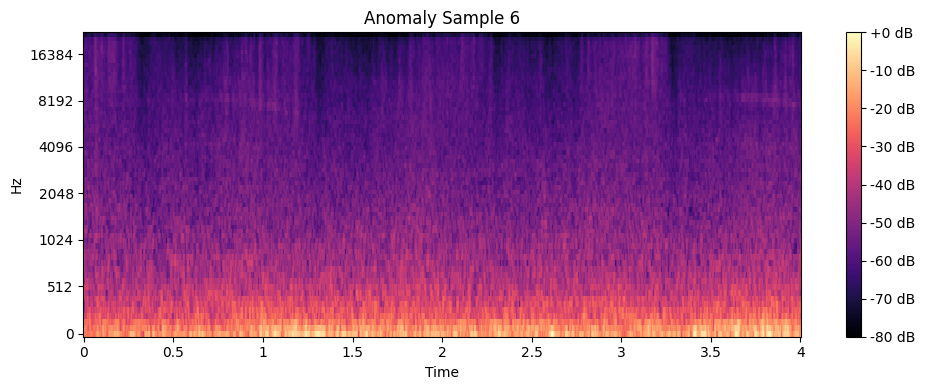

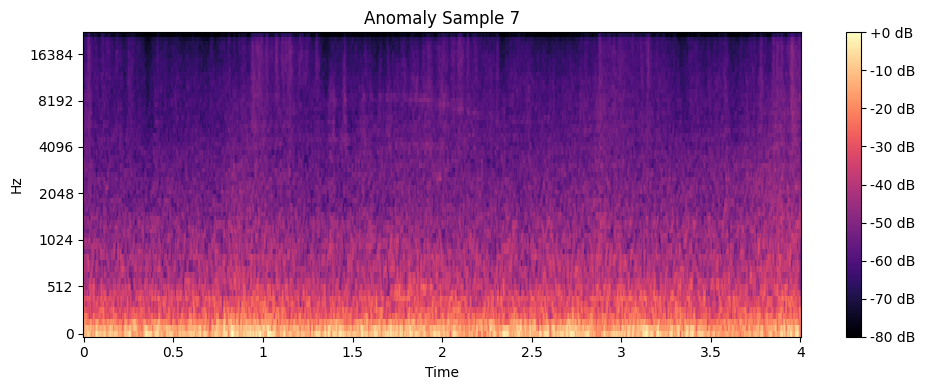

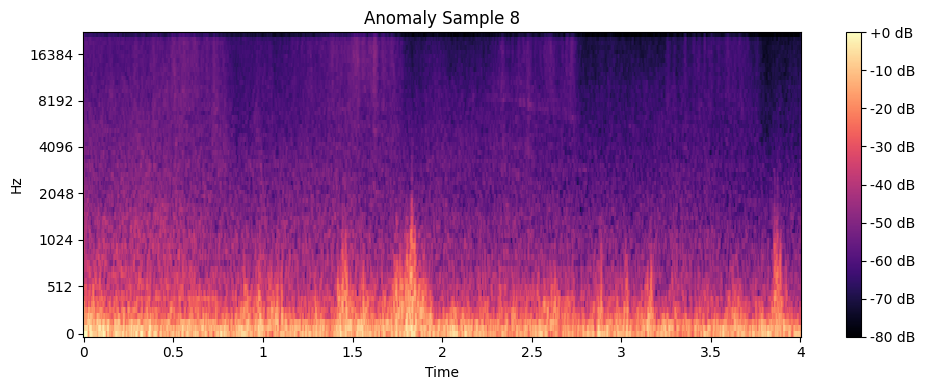

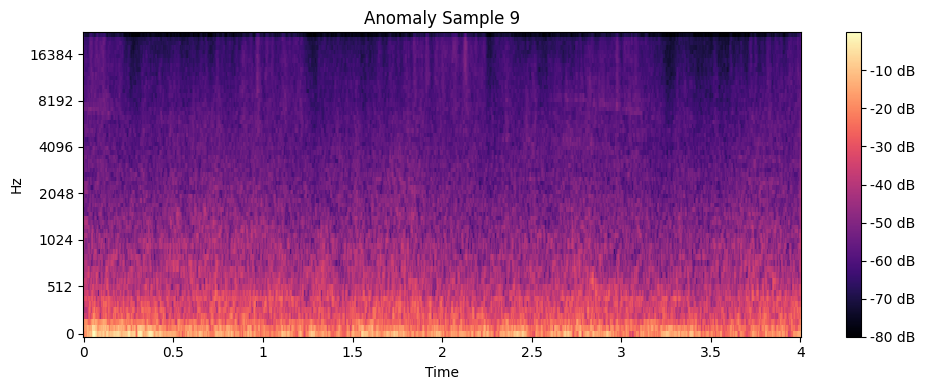

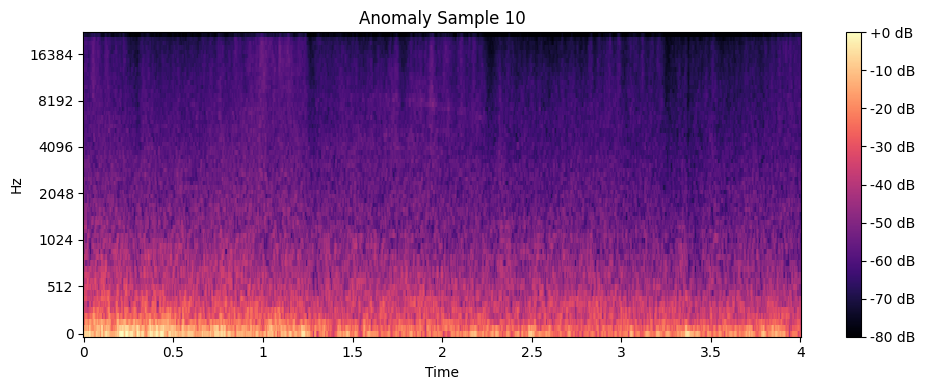

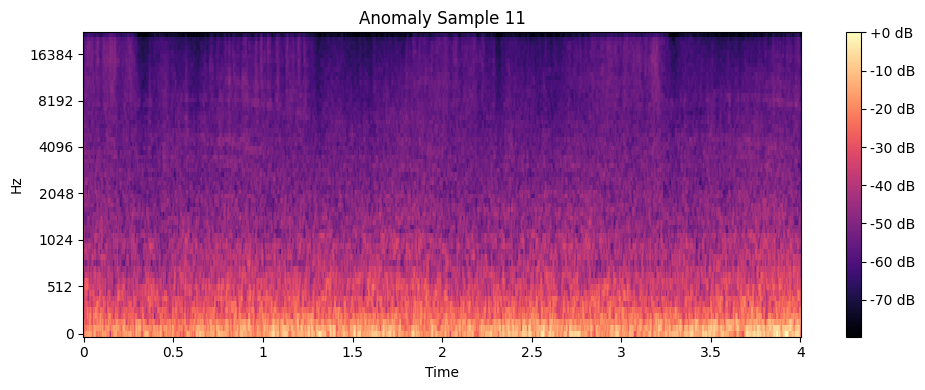

In [8]:
import matplotlib.pyplot as plt
for i, mel_spectrogram in enumerate(mel_spectrograms_normal[:11]):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Normal Sample {i+1}')
    plt.tight_layout()
    plt.show()

for i, mel_spectrogram in enumerate(mel_spectrograms_anomaly[:11]):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Anomaly Sample {i+1}')
    plt.tight_layout()
    plt.show()



# 分割資料集

# 將正常和異常樣本合併

In [9]:
X = mel_spectrograms_normal + mel_spectrograms_anomaly
y = [0] * len(mel_spectrograms_normal) + [1] * len(mel_spectrograms_anomaly)

In [10]:
# 將梅爾頻譜圖轉換為 NumPy 數組
X = np.array(X)
y = np.array(y)
# 數據歸一化到 [0, 1]
X = (X - X.min()) / (X.max() - X.min())

In [11]:
X[490]

array([[0.6604787 , 0.7478512 , 0.7260109 , ..., 0.84789926, 0.7750226 ,
        0.74386394],
       [0.66747487, 0.80606014, 0.8166114 , ..., 0.8125809 , 0.789749  ,
        0.73887515],
       [0.63137615, 0.7956606 , 0.8201253 , ..., 0.6986696 , 0.6432845 ,
        0.6724297 ],
       ...,
       [0.37969598, 0.42281574, 0.42747647, ..., 0.2844785 , 0.28096065,
        0.23886171],
       [0.34648404, 0.39141592, 0.39970335, ..., 0.2604905 , 0.29179683,
        0.27088863],
       [0.25012428, 0.28270906, 0.30902666, ..., 0.1756014 , 0.20427828,
        0.17287025]], dtype=float32)

# 打亂資料集

In [12]:
combined = list(zip(X, y))
np.random.shuffle(combined)
X[:], y[:] = zip(*combined)

In [13]:
combined[1][0]

array([[0.7226743 , 0.80613136, 0.7725257 , ..., 0.8371997 , 0.8470866 ,
        0.8891715 ],
       [0.6876691 , 0.7024994 , 0.75187373, ..., 0.8106526 , 0.8681692 ,
        0.89049184],
       [0.61180794, 0.56949157, 0.70393944, ..., 0.7956444 , 0.829476  ,
        0.8496164 ],
       ...,
       [0.19358082, 0.20652933, 0.20941   , ..., 0.18389206, 0.22617093,
        0.26725465],
       [0.18709326, 0.21461025, 0.2109725 , ..., 0.17252502, 0.202674  ,
        0.23682208],
       [0.14278479, 0.12586327, 0.10386734, ..., 0.09685602, 0.16471577,
        0.23544721]], dtype=float32)

# Spilt Dataset to training and testing

In [14]:
# 對數據進行切分
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("訓練集數據形狀:", X_train.shape)
print("驗證集數據形狀:", X_val.shape)
print("測試集數據形狀:", X_test.shape)
print("訓練集標籤形狀:", y_train.shape)
print("驗證集標籤形狀:", y_val.shape)
print("測試集標籤形狀:", y_test.shape)

訓練集數據形狀: (2486, 64, 690)
驗證集數據形狀: (311, 64, 690)
測試集數據形狀: (311, 64, 690)
訓練集標籤形狀: (2486,)
驗證集標籤形狀: (311,)
測試集標籤形狀: (311,)


# 儲存資料集（選擇性）

In [15]:
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)